In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

2026-02-28 17:23:08.835532: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1772299389.013288      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1772299389.064978      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1772299389.477338      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772299389.477383      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772299389.477386      55 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
GPU available: True


In [4]:
data_dir = Path('/kaggle/input/datasets/emmarex/plantdisease/PlantVillage')
processed_dir = Path('/kaggle/input/datasets/samuelkarikari/plant-village-processed-v2')
models_dir = Path('/kaggle/working/models')
models_dir.mkdir(parents=True, exist_ok=True)

# Load artifacts
with open(processed_dir / "preprocessing_config.json") as f:
    config = json.load(f)

with open(processed_dir / "class_to_index.json") as f:
    class_to_index = json.load(f)

with open(processed_dir / "index_to_class.json") as f:
    index_to_class = {int(k): v for k, v in json.load(f).items()}

with open(processed_dir / "class_weights.json") as f:
    class_weights = {int(k): v for k, v in json.load(f).items()}

# EfficientNetB0 expects 224x224
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
N_CLASSES = len(class_to_index)
RANDOM_SEED = config['random_seed']

print(f"Classes: {N_CLASSES}")
print(f"Image size: {IMAGE_SIZE}")
print(f"Batch size: {BATCH_SIZE}")

Classes: 15
Image size: (224, 224)
Batch size: 32


In [5]:
train_df = pd.read_csv(processed_dir / "train.csv")
val_df = pd.read_csv(processed_dir / "val.csv")
test_df = pd.read_csv(processed_dir / "test.csv")

def fix_path(p):
    return str(data_dir / Path(p).parent.name / Path(p).name)

train_df['image_path'] = train_df['image_path'].apply(fix_path)
val_df['image_path'] = val_df['image_path'].apply(fix_path)
test_df['image_path'] = test_df['image_path'].apply(fix_path)

print(f"Train: {len(train_df)} images")
print(f"Val:   {len(val_df)} images")
print(f"Test:  {len(test_df)} images")
print(f"\nSample path: {train_df['image_path'].iloc[0]}")
print(f"File exists: {Path(train_df['image_path'].iloc[0]).exists()}")

Train: 14227 images
Val:   3049 images
Test:  3049 images

Sample path: /kaggle/input/datasets/emmarex/plantdisease/PlantVillage/Tomato_Septoria_leaf_spot/caf6c8f5-e7ba-4d75-98ef-9b2c0dffcaaa___Keller.St_CG 1792.JPG
File exists: True


In [6]:
def augment_standard(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image

def augment_aggressive(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_hue(image, max_delta=0.05)
    return image

MINORITY_CLASSES = [
    cls for cls, idx in class_to_index.items()
    if len(train_df[train_df['class_name'] == cls]) < 500
]
print(f"Minority classes: {MINORITY_CLASSES}")

minority_indices = [class_to_index[cls] for cls in MINORITY_CLASSES]

Minority classes: ['Potato___healthy', 'Tomato__Tomato_mosaic_virus']


In [7]:
def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    # EfficientNetB0 expects pixels in 0-255 range
    # Its preprocessing layer handles normalization internally
    image = tf.cast(image, tf.float32)
    return image, label

def apply_augmentation(image, label):
    is_minority = tf.reduce_any(
        tf.equal(label, tf.constant(minority_indices, dtype=tf.int64))
    )
    image = tf.cond(
        is_minority,
        lambda: augment_aggressive(image),
        lambda: augment_standard(image)
    )
    return image, label

def build_dataset(df, is_training=False, shuffle=False):
    paths = df['image_path'].values
    labels = df['class_index'].values.astype(np.int64)

    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df), seed=RANDOM_SEED)

    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

    if is_training:
        dataset = dataset.map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = build_dataset(train_df, is_training=True, shuffle=True)
val_dataset = build_dataset(val_df, is_training=False, shuffle=False)
test_dataset = build_dataset(test_df, is_training=False, shuffle=False)

print("Datasets built successfully")

for images, labels in train_dataset.take(1):
    print(f"Batch image shape: {images.shape}")
    print(f"Batch label shape: {labels.shape}")
    print(f"Label dtype: {labels.dtype}")

I0000 00:00:1772299423.526284      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1772299423.528880      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Datasets built successfully
Batch image shape: (32, 224, 224, 3)
Batch label shape: (32,)
Label dtype: <dtype: 'int64'>


In [8]:
def build_transfer_model(n_classes, trainable_backbone=False):
    # Load EfficientNetB0 with ImageNet weights
    backbone = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )
    backbone.trainable = trainable_backbone

    inputs = keras.Input(shape=(224, 224, 3))

    # EfficientNetB0 has its own preprocessing built in
    x = keras.applications.efficientnet.preprocess_input(inputs)
    x = backbone(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

model = build_transfer_model(N_CLASSES, trainable_backbone=False)
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,387,506 (16.74 MB)

 Trainable params: 334,863 (1.28 MB)

 Non-trainable params: 4,052,643 (15.46 MB)

In [9]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Phase 1 — Backbone frozen, training head only")
print(f"Trainable params: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")

Phase 1 — Backbone frozen, training head only
Trainable params: 334,863


In [10]:
phase1_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath=str(models_dir / 'phase1_best.keras'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-6,
        verbose=1
    )
]

In [11]:
print("Starting Phase 1 training — frozen backbone...")

history_phase1 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    class_weight=class_weights,
    callbacks=phase1_callbacks,
    verbose=1
)

print("Phase 1 complete.")

Starting Phase 1 training — frozen backbone...
Epoch 1/20


I0000 00:00:1772299447.464021     128 service.cc:152] XLA service 0x7aab24116400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1772299447.464061     128 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1772299447.464065     128 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1772299450.084211     128 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-02-28 17:24:17.145298: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-28 17:24:17.289628: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-28 17:24:17.629922: E external/local_xl

444/445 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.6367 - loss: 1.1947

2026-02-28 17:25:50.175522: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-28 17:25:50.317256: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-28 17:25:50.650885: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-28 17:25:50.793654: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-28 17:25:50.935013: E external/local_xla/xla/stream_

445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.6369 - loss: 1.1937

2026-02-28 17:26:22.052584: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-28 17:26:22.189511: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-28 17:26:22.499948: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-28 17:26:22.641412: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-28 17:26:23.382164: E external/local_xla/xla/stream_


Epoch 1: val_loss improved from inf to 0.28020, saving model to /kaggle/working/models/phase1_best.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 152s 274ms/step - accuracy: 0.6372 - loss: 1.1928 - val_accuracy: 0.9105 - val_loss: 0.2802 - learning_rate: 0.0010
Epoch 2/20
444/445 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8556 - loss: 0.4101
Epoch 2: val_loss improved from 0.28020 to 0.18570, saving model to /kaggle/working/models/phase1_best.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.8556 - loss: 0.4099 - val_accuracy: 0.9416 - val_loss: 0.1857 - learning_rate: 0.0010
Epoch 3/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8816 - loss: 0.3412
Epoch 3: val_loss improved from 0.18570 to 0.15896, saving model to /kaggle/working/models/phase1_best.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.8816 - loss: 0.3412 - val_accuracy: 0.9472 - val_loss: 0.1590 - learning_rate: 0.0010
Epoch 4/20
444/445 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8987

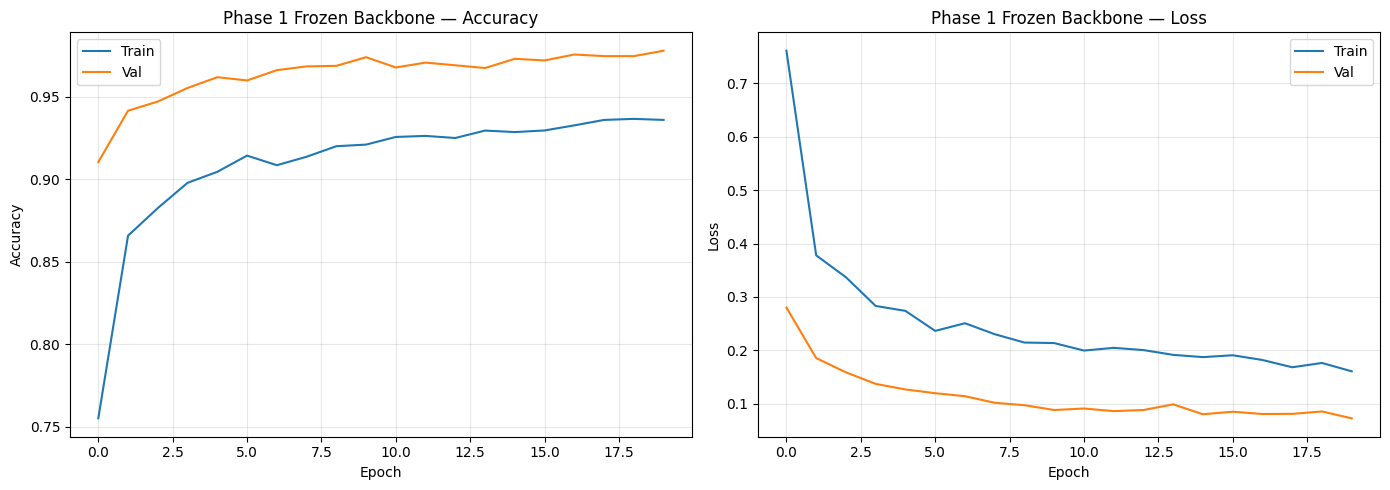

In [12]:
def plot_history(history, title):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(history.history['accuracy'], label='Train')
    axes[0].plot(history.history['val_accuracy'], label='Val')
    axes[0].set_title(f'{title} — Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(history.history['loss'], label='Train')
    axes[1].plot(history.history['val_loss'], label='Val')
    axes[1].set_title(f'{title} — Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(str(models_dir / f'{title.lower().replace(" ", "_")}_curves.png'), dpi=150)
    plt.show()

plot_history(history_phase1, 'Phase 1 Frozen Backbone')

In [13]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, type(layer).__name__)

0 input_layer_1 InputLayer
1 efficientnetb0 Functional
2 global_average_pooling2d GlobalAveragePooling2D
3 batch_normalization BatchNormalization
4 dropout Dropout
5 dense Dense
6 batch_normalization_1 BatchNormalization
7 dropout_1 Dropout
8 dense_1 Dense


In [15]:
print("Starting Phase 2 — unfreezing top layers for fine-tuning...")

# Unfreeze the backbone
model.layers[1].trainable = True

# Freeze all layers except the last 30
for layer in model.layers[1].layers[:-30]:
    layer.trainable = False

print(f"Trainable params after unfreezing: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")

# Recompile with much lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

phase2_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath=str(models_dir / 'best_model.keras'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

history_phase2 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    class_weight=class_weights,
    callbacks=phase2_callbacks,
    verbose=1
)

print("Phase 2 complete.")

Starting Phase 2 — unfreezing top layers for fine-tuning...
Trainable params after unfreezing: 1,831,023
Epoch 1/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7746 - loss: 0.8002
Epoch 1: val_loss improved from inf to 0.17893, saving model to /kaggle/working/models/best_model.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 79s 111ms/step - accuracy: 0.7746 - loss: 0.8000 - val_accuracy: 0.9370 - val_loss: 0.1789 - learning_rate: 1.0000e-05
Epoch 2/50
444/445 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8286 - loss: 0.5277
Epoch 2: val_loss improved from 0.17893 to 0.15132, saving model to /kaggle/working/models/best_model.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.8287 - loss: 0.5276 - val_accuracy: 0.9505 - val_loss: 0.1513 - learning_rate: 1.0000e-05
Epoch 3/50
444/445 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8550 - loss: 0.4308
Epoch 3: val_loss improved from 0.15132 to 0.13143, saving model to /kaggle/working/models/best_model.keras
445/445 ━━━━━━━━━━━

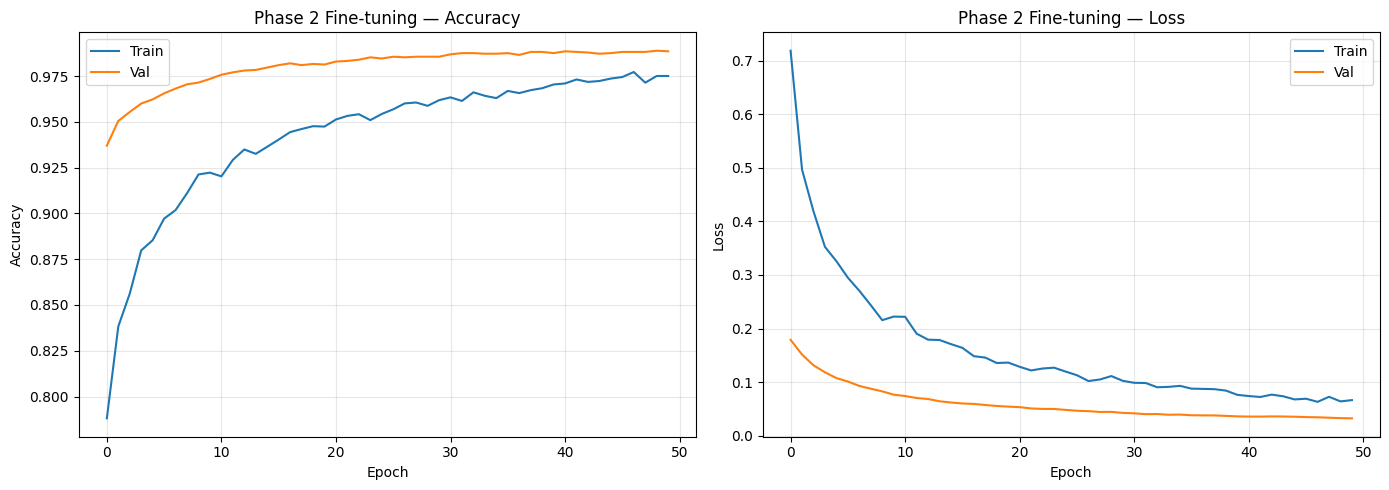

In [18]:
plot_history(history_phase2, 'Phase 2 Fine-tuning')

In [16]:
best_model = keras.models.load_model(str(models_dir / 'best_model.keras'))

test_loss, test_accuracy = best_model.evaluate(test_dataset, verbose=1)
print(f"\nTest Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = best_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.9844 - loss: 0.0424

Test Loss:     0.0376
Test Accuracy: 0.9862


In [17]:
flagged_classes = ['Potato___healthy', 'Tomato__Tomato_mosaic_virus']

print("Per-class accuracy for flagged minority classes:")
for class_name in flagged_classes:
    idx = class_to_index[class_name]
    mask = y_true == idx
    if mask.sum() > 0:
        acc = (y_pred[mask] == y_true[mask]).mean()
        print(f"  {class_name}: {acc:.4f} ({mask.sum()} test images)")

Per-class accuracy for flagged minority classes:
  Potato___healthy: 0.9565 (23 test images)
  Tomato__Tomato_mosaic_virus: 1.0000 (56 test images)


                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      1.00      1.00       150
                     Pepper__bell___healthy       1.00      1.00      1.00       221
                      Potato___Early_blight       1.00      1.00      1.00       150
                       Potato___Late_blight       0.99      0.99      0.99       150
                           Potato___healthy       0.96      0.96      0.96        23
                      Tomato_Bacterial_spot       0.99      0.99      0.99       316
                        Tomato_Early_blight       0.97      0.95      0.96       148
                         Tomato_Late_blight       0.98      0.99      0.99       259
                           Tomato_Leaf_Mold       1.00      0.99      1.00       142
                  Tomato_Septoria_leaf_spot       0.98      0.97      0.98       264
Tomato_Spider_mites_Two_spotted_spider_mite       0.96      0.98

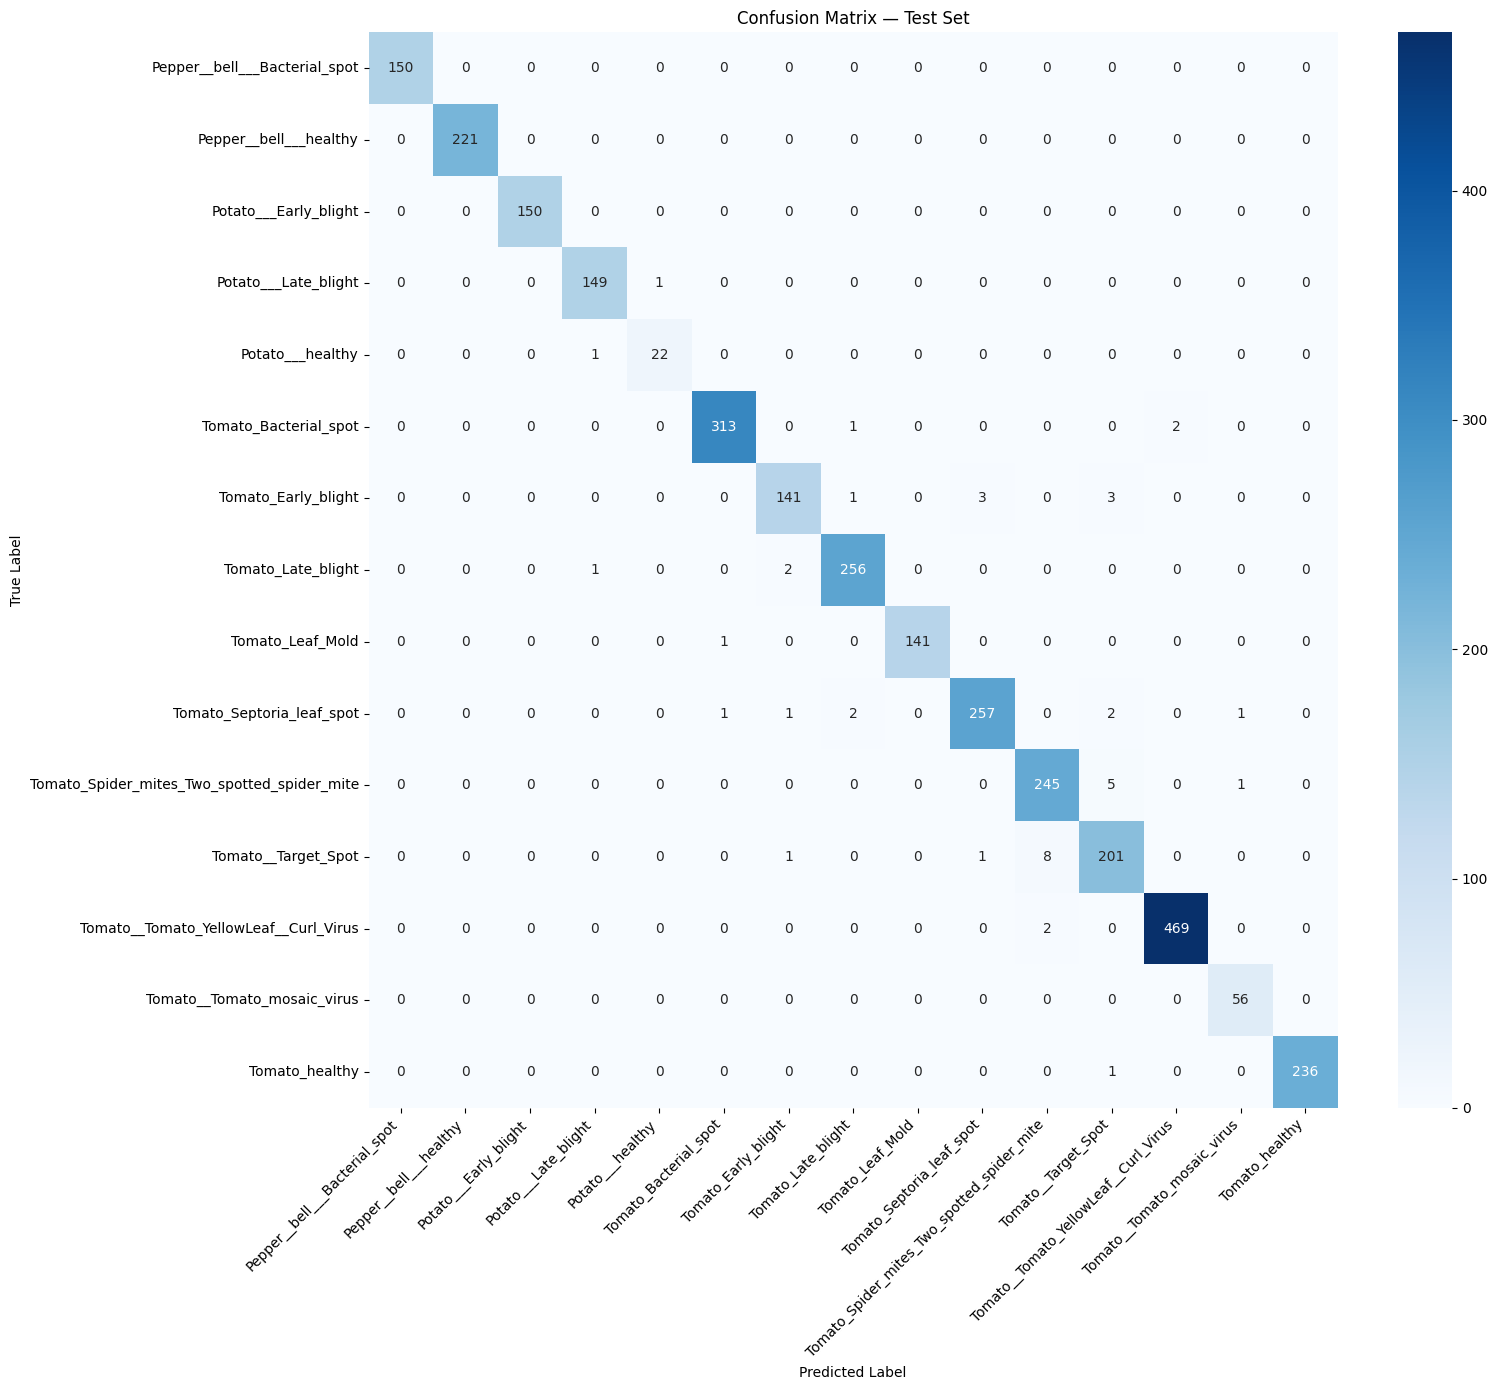

In [19]:
class_names = [index_to_class[i] for i in range(N_CLASSES)]
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(16, 14))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title('Confusion Matrix — Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(str(models_dir / 'confusion_matrix.png'), dpi=150)
plt.show()